# Построение логистической регрессии на датасете moons, собственной полносвязной нейросети и свёрточной нейросети LeNet на датасете MNIST








### Импорт библиотек

In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Сгенерируем датасет и посмотрим на него

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

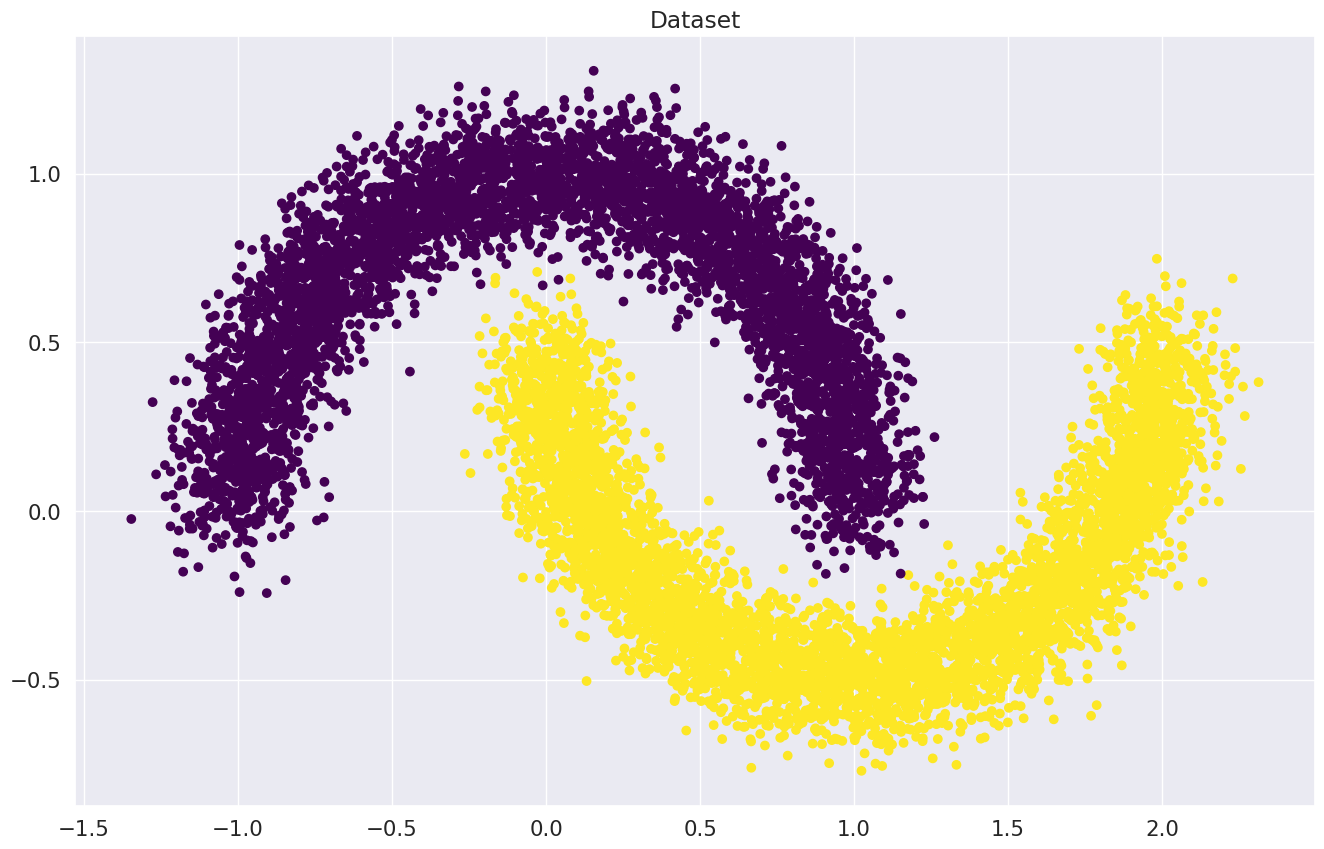

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

In [ ]:
X_train_t =  torch.from_numpy(X_train).type(torch.float32)
y_train_t =  torch.from_numpy(y_train).type(torch.float32)
X_val_t =  torch.from_numpy(X_val).type(torch.float32)
y_val_t =  torch.from_numpy(y_val).type(torch.float32)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Реализация логистической регрессии

модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn([in_features, out_features]))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)
sigmoid = nn.Sigmoid()

### Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch.reshape(-1, 1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.640625
Iteration: 200
Batch accuracy: 0.7734375
Iteration: 300
Batch accuracy: 0.859375
Iteration: 400
Batch accuracy: 0.8359375
Iteration: 500
Batch accuracy: 0.875
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.8046875
Iteration: 800
Batch accuracy: 0.828125

Iteration: 877.Convergence. Stopping iterations.


### Визуализируем результаты

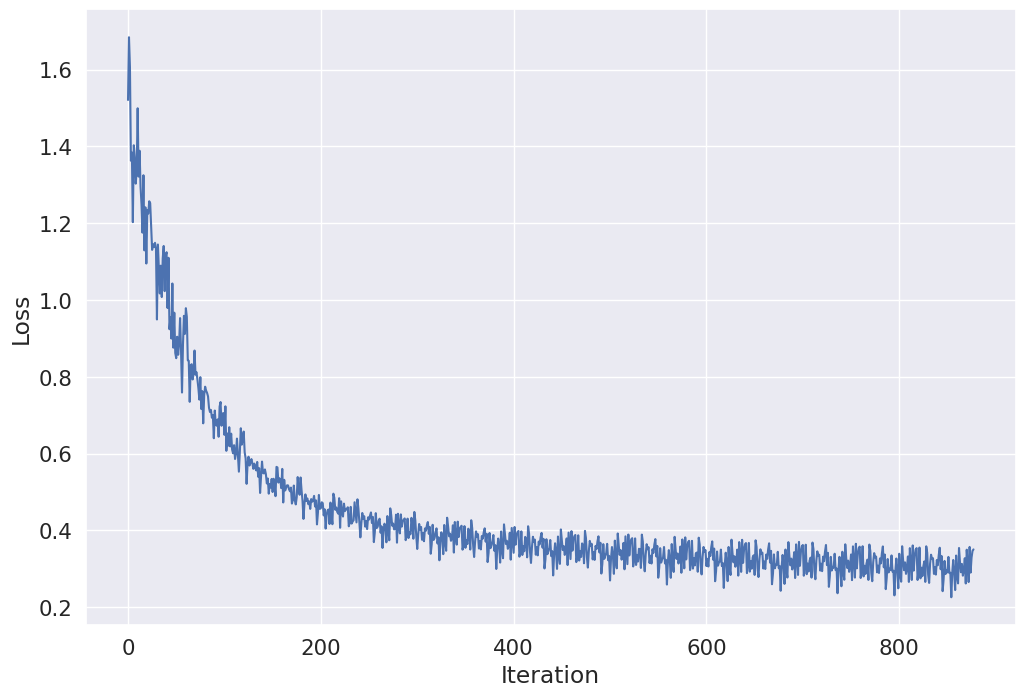

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

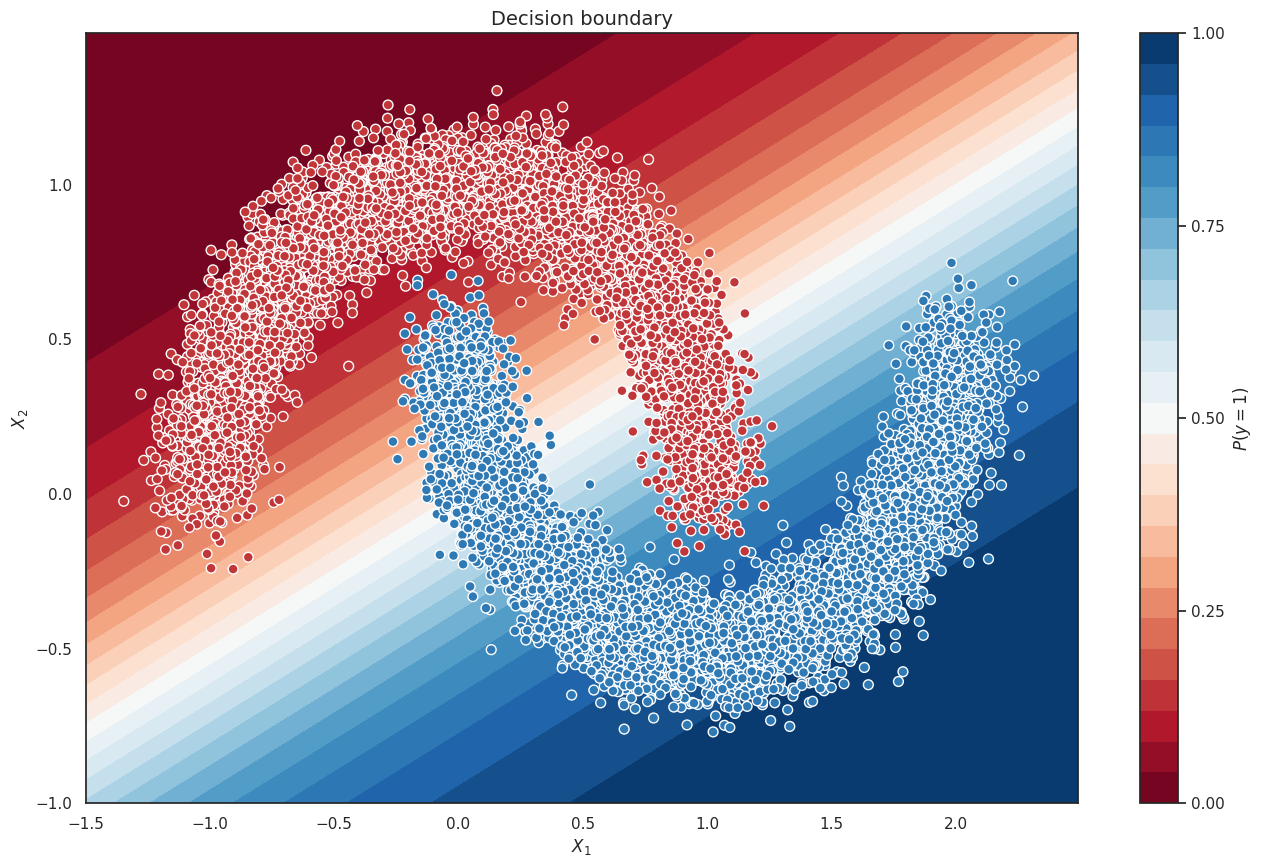

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # Проходим по батчам и получаем logits
        outp = linear_regression(x_batch)  # Получаем "логиты" из модели
        preds = (torch.sigmoid(outp) > 0.5).type(torch.long)  # получаем метку принадлежности классу
        predictions = np.hstack((predictions, preds.numpy().flatten()))  # Объединяем предсказания
    return predictions.flatten()  # Возвращаем 1D массив предсказаний

In [ ]:
y_pred = predict(val_dataloader, linear_regression)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)

In [ ]:
print(f'Accuracy после обучения: {accuracy}')

Accuracy после обучения: 0.8604


# Часть 2. Датасет MNIST


In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size = 100)
valid_dataloader =  DataLoader(val_dataset, batch_size = 100)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 33.6MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.52MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Простая полносвязная нейронная сеть

Создадим олносвязную нейронную сеть с помощью класса Sequential, состоящую из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.


In [ ]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128), activation(), nn.Linear(128, 128), activation(), nn.Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Цикл обучения

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                 with torch.no_grad():
                    outp = model(x_batch)
                 outp = model(x_batch)
            preds = outp.argmax(-1)

            correct = (preds.flatten() == y_batch).type(torch.float32).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


KeyboardInterrupt: 

### Тестируем различные функции активации

In [ ]:
elu_accuracy = accuracy["valid"]
print(elu_accuracy)

[0.9765, 0.9734, 0.9729, 0.9706, 0.9725, 0.9717, 0.9723, 0.9749, 0.9794, 0.9735]


In [ ]:
def test_activation_function(activation):
    model = nn.Sequential(nn.Flatten(),
    nn.Linear(28 * 28, 128), activation(), nn.Linear(128, 128), activation(), nn.Linear(128, 10)
)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    accuracy = get_accuracy(model, optimizer, criterion)
    val_accuracy = accuracy["valid"]
    return val_accuracy



def get_accuracy(model, optimizer, criterion):
    """Возвращает accuracy модели на train и на validation выборках
    """
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)

                correct = (preds.flatten() == y_batch).type(torch.float32).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
            accuracy[k].append(epoch_correct/epoch_all)


    return accuracy



In [ ]:
plain_accuracy = test_activation_function(Identical)

In [ ]:
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

In [ ]:
print(plain_accuracy)
print(relu_accuracy)
print(leaky_relu_accuracy)
print(elu_accuracy)

[0.876, 0.8828, 0.8863, 0.891, 0.8942, 0.8974, 0.8984, 0.9009, 0.9026, 0.9041]
[0.9182, 0.9421, 0.9571, 0.9601, 0.9636, 0.9674, 0.9696, 0.9699, 0.9718, 0.9685]
[0.9207, 0.9475, 0.9594, 0.9632, 0.9666, 0.9627, 0.9711, 0.9707, 0.9749, 0.9727]
[0.9765, 0.9734, 0.9729, 0.9706, 0.9725, 0.9717, 0.9723, 0.9749, 0.9794, 0.9735]


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

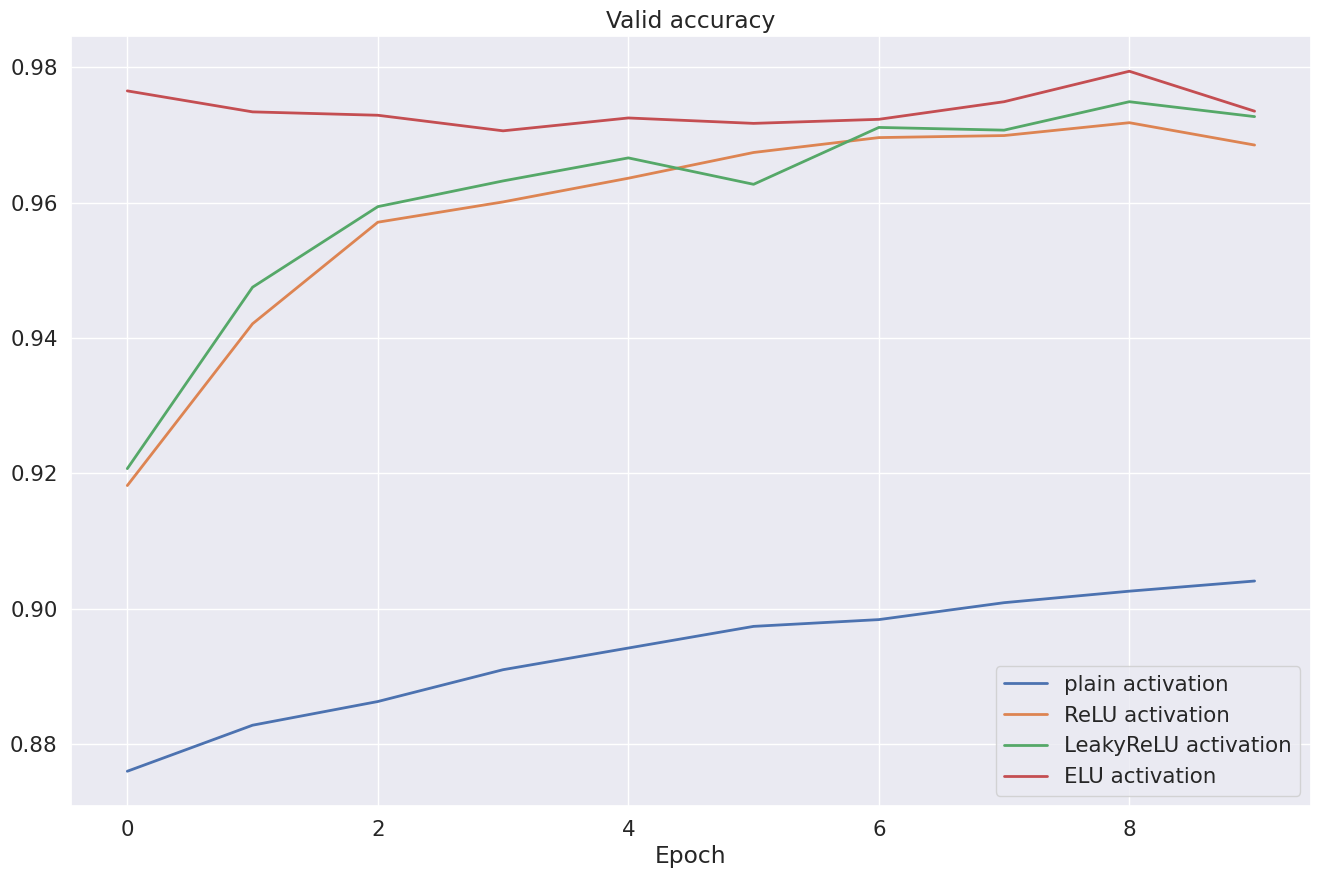

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
# plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), plain_accuracy, label="plain activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Наилучший accuracy к концу обучения показывает модель с активацией ELU: 0.9735

## Часть 2.2 Сверточные нейронные сети

### Ядра


In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-11-14 12:42:41--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   209KB/s    in 0.2s    

2024-11-14 12:42:41 (209 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



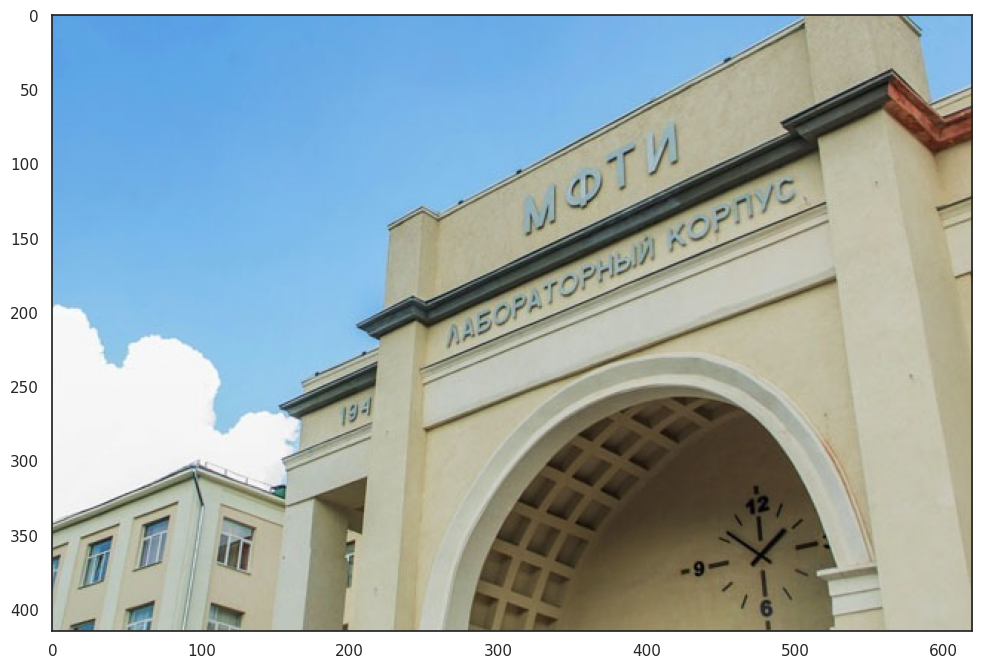

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Посмотрим, как различные свертки влияют на фото. Например,

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)
kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

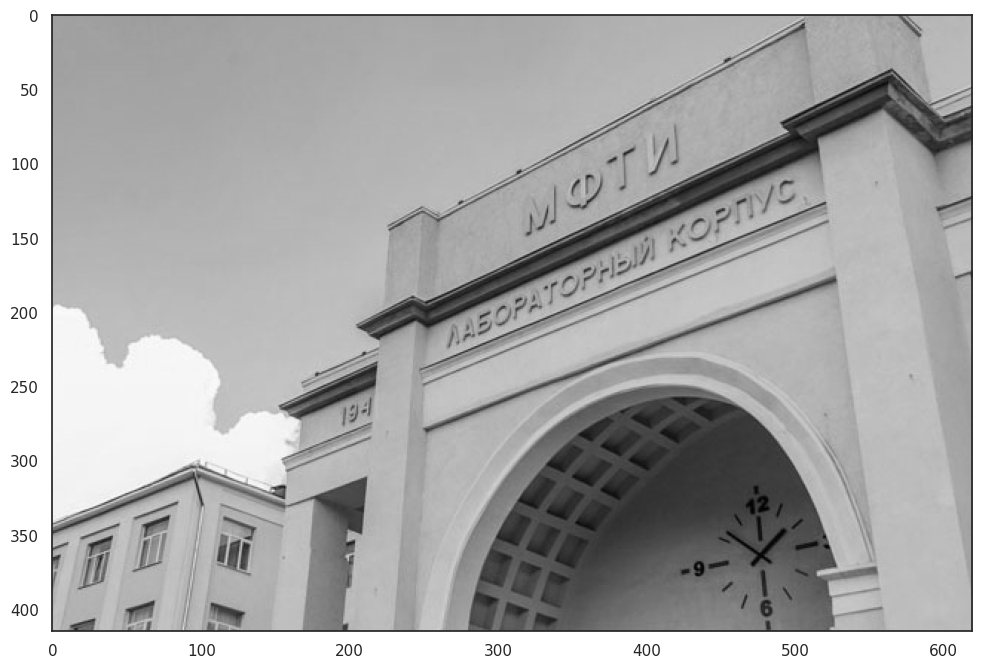

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Создадим ядра А, Б, ..., Е и выведем результаты их применения к изображению

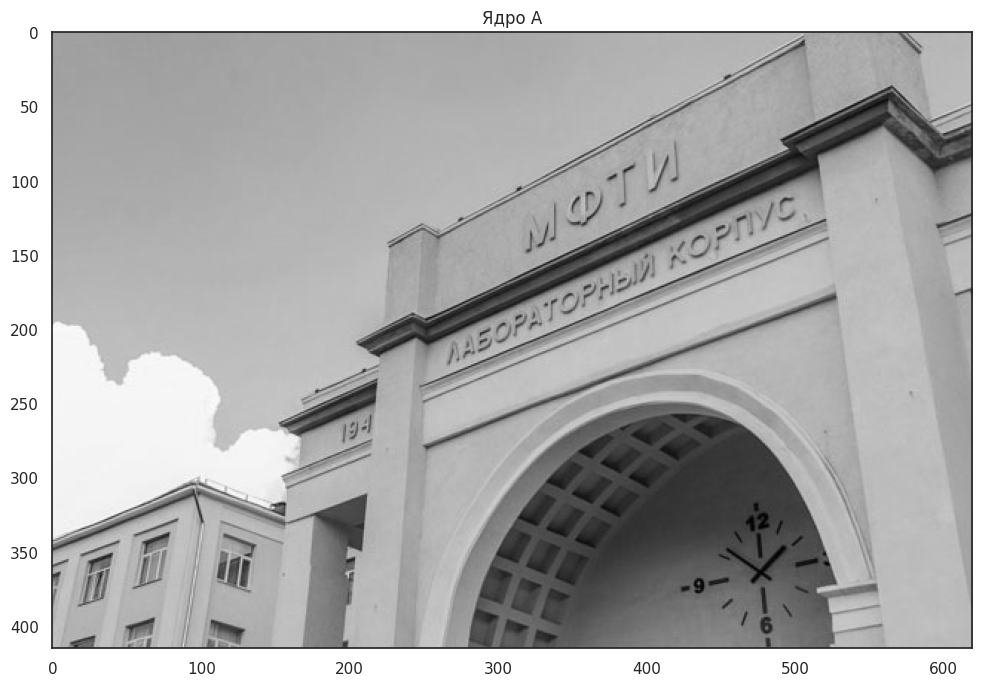

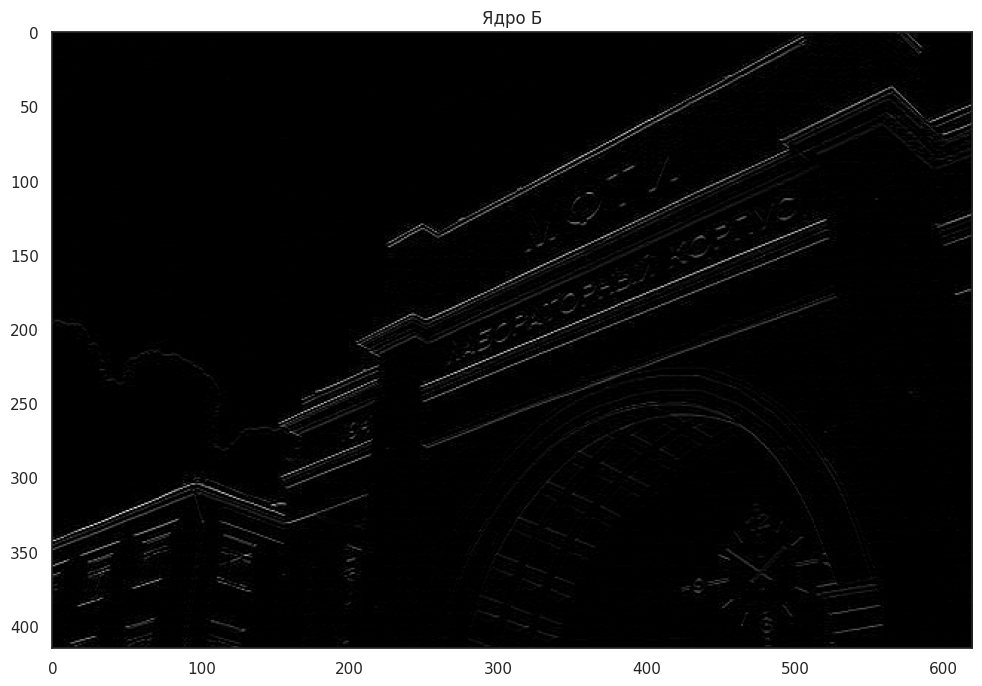

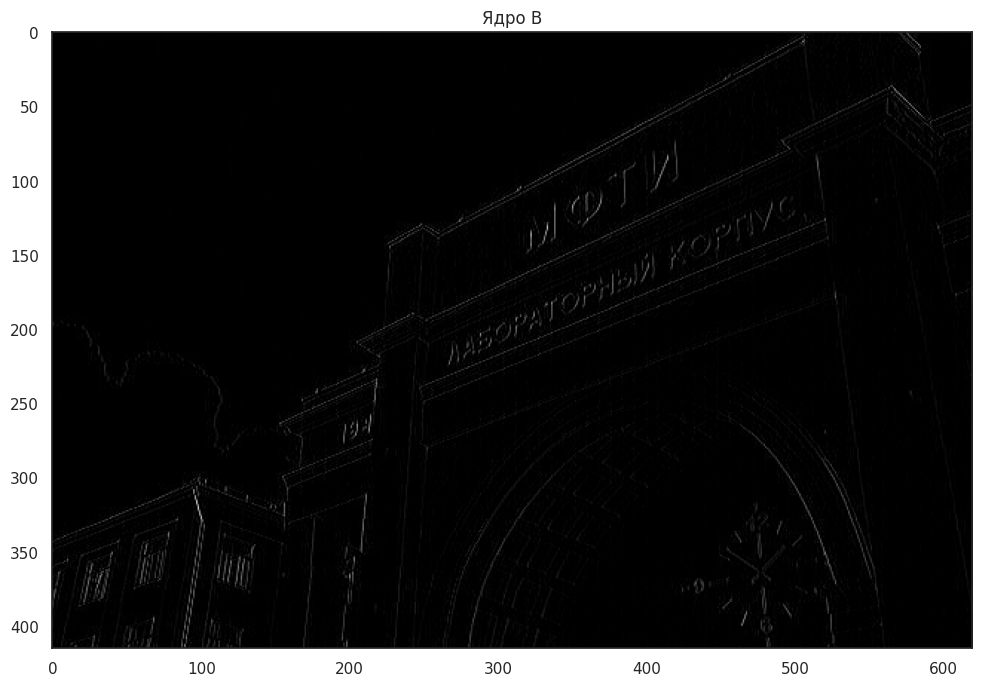

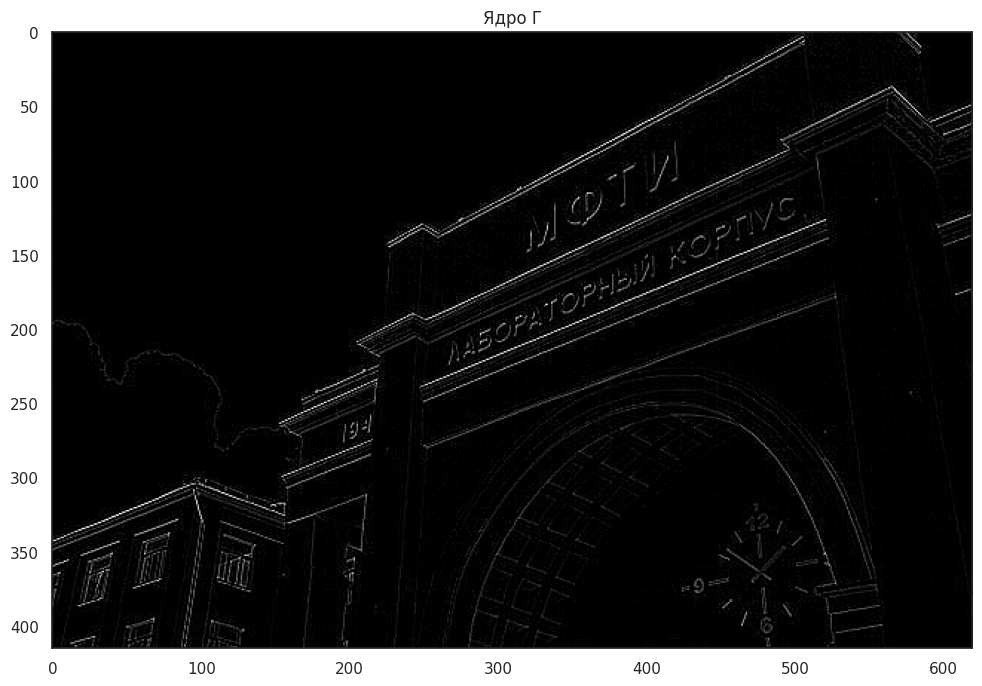

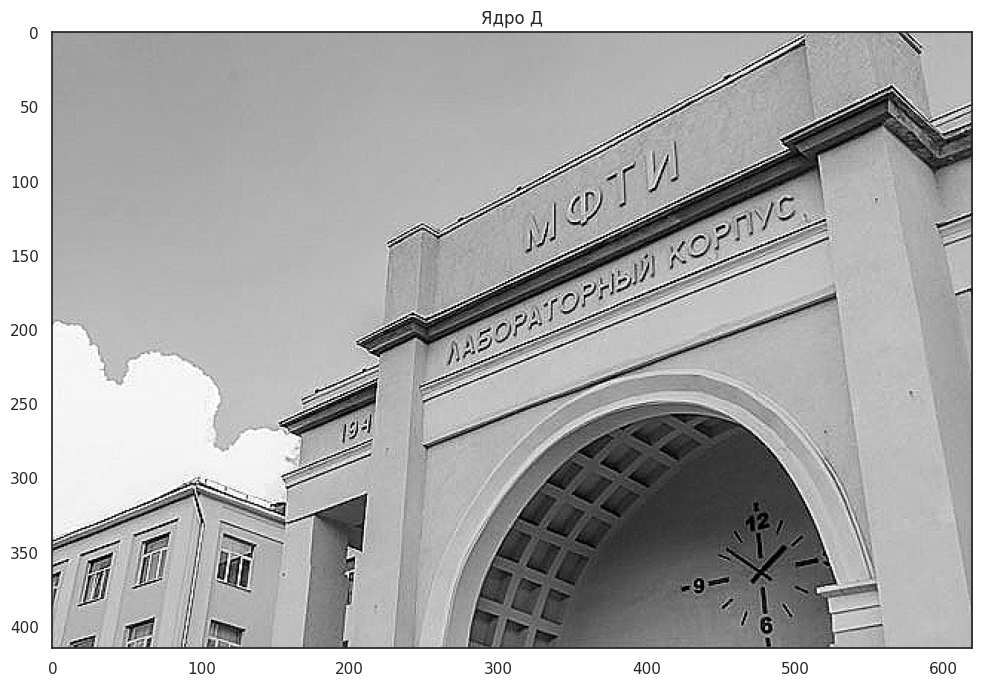

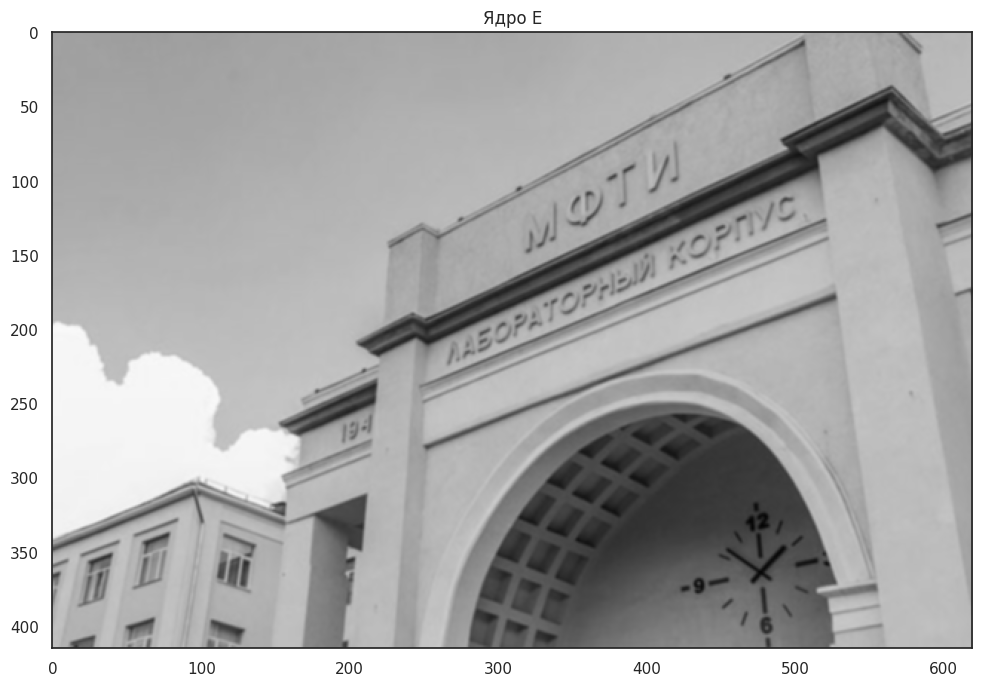

In [ ]:
kernel_1 = [[0, 0, 0],
            [0, 1, 0],
            [0, 0, 0]]

kernel_2 = [[0, 1, 0],
            [0, -2, 0],
             [0, 1, 0]]

kernel_3 = [[0, 0, 0],
            [1, -2, 1],
            [0, 0, 0]]

kernel_4 = [[0, 1, 0],
            [1, -4, 1],
            [0, 1, 0]]

kernel_5 = [[0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]]

kernel_6 = [[0.0625, 0.125, 0.0625],
            [0.125, 0.25, 0.125],
            [0.0625, 0.125, 0.0625]]

kernels = {"A": kernel_1, "Б": kernel_2, "В": kernel_3, "Г": kernel_4, "Д": kernel_5, "E": kernel_6}

for k, kernel in kernels.items():
  kernel = torch.tensor(kernel).reshape(1, 1, 3, 3).type(torch.float32)
  kernel = kernel.repeat(3, 3, 1, 1)
  result = F.conv2d(img_t, kernel)[0]
  plt.figure(figsize=(12, 8))
  result_np = result.permute(1, 2, 0).numpy() / 256 / 3
  plt.title(f'Ядро {k}')
  plt.imshow(result_np)
  plt.show()


Действия ядер можно описать следующим образом:
1) Размытие -- E

2) Увеличение резкости -- Д

3) Тождественное преобразование -- A

4) Выделение вертикальных границ -- В

5) Выделение горизонтальных границ -- Б

6) Выделение границ -- Г



Посмотрим на результат применения ядра, которое выделяет границы объектов на изображении.

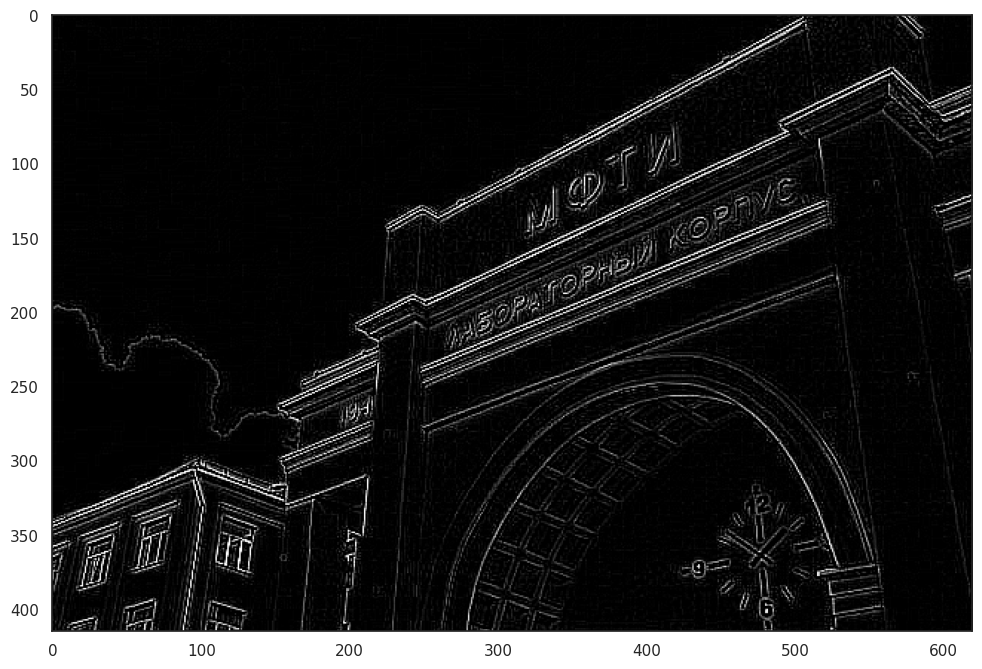

In [ ]:
my_kernel = [[-1, -1, -1],
             [-1, 8, -1],
             [-1, -1, -1]]
kernel = torch.tensor(my_kernel).reshape(1, 1, 3, 3).type(torch.float32)
kernel = kernel.repeat(3, 3, 1, 1)
result = F.conv2d(img_t, kernel)[0]
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3
plt.imshow(result_np)
plt.show()

### Реализация LeNet
Архитектура будет состоять из:
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3)
        self.fc1 = nn.Linear(5 * 5 * 16, 120, bias=True)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 5*5*16)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучение CNN

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                 with torch.no_grad():
                    outp = model(x_batch)
                 outp = model(x_batch)
            preds = outp.argmax(-1)

            correct = (preds.flatten() == y_batch).type(torch.float32).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8889833333333333
Loader: valid. Accuracy: 0.9645
Epoch: 2
Loader: train. Accuracy: 0.9686166666666667
Loader: valid. Accuracy: 0.976
Epoch: 3
Loader: train. Accuracy: 0.97905
Loader: valid. Accuracy: 0.9812
Epoch: 4
Loader: train. Accuracy: 0.9837833333333333
Loader: valid. Accuracy: 0.9827
Epoch: 5
Loader: train. Accuracy: 0.9872666666666666
Loader: valid. Accuracy: 0.9836
Epoch: 6
Loader: train. Accuracy: 0.9892666666666666
Loader: valid. Accuracy: 0.9848
Epoch: 7
Loader: train. Accuracy: 0.99125
Loader: valid. Accuracy: 0.9848
Epoch: 8
Loader: train. Accuracy: 0.9927833333333334
Loader: valid. Accuracy: 0.9866
Epoch: 9
Loader: train. Accuracy: 0.99375
Loader: valid. Accuracy: 0.9879
Epoch: 10
Loader: train. Accuracy: 0.9941666666666666
Loader: valid. Accuracy: 0.9891


In [ ]:
lenet_accuracy = accuracy["valid"]

Используем написанную ранее реализацию полносвязной нейронной сети и найдём accuracy для следующих функций активации: relu, leaky_relu и elu

In [ ]:
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
elu_accuracy = test_activation_function(nn.ELU)

Сравним с предыдущем пунктом

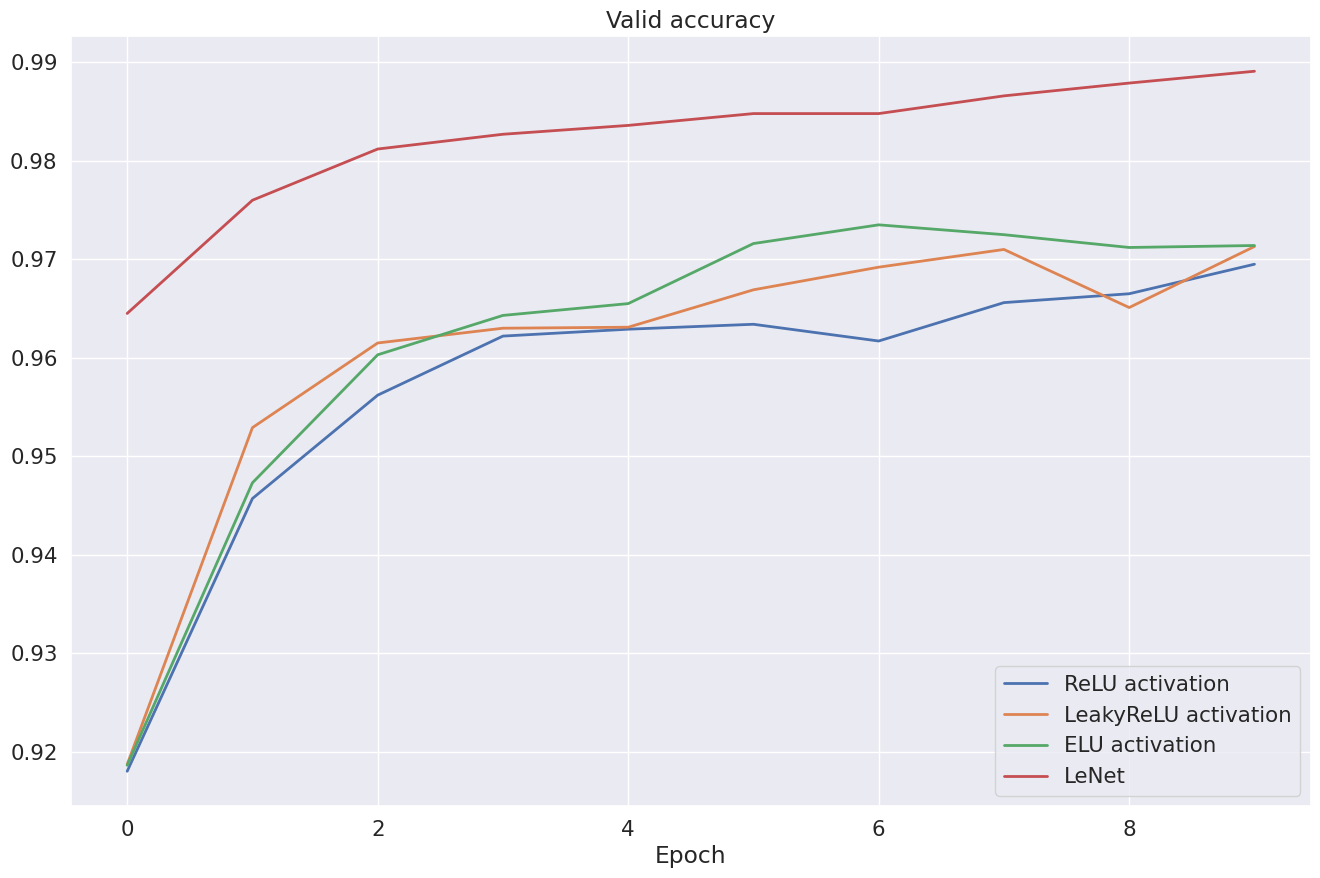

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

наивысшее accuracy получается у LeNet на 10 эпохе, accuracy = 0.99